# Spatial and temporal subsetting

A common task in climate data analysis is subsetting files over a region of interest. Global model simulations and observations cover the entire globe, while impact analyses are often concerned with a region. Instead of downloading the entire file on a local disk, it is often more practical to subset it on the server and only download the relevant part.

This notebook shows two ways subsetting can be done. The first is to access the file using OPeNDAP, and select the coordinates of interest. The second uses  processes defined on the PAVICS server.

## Subsetting with OPeNDAP

 Let's start with the most direct approach using the OPeNDAP data streaming protocol. For this you'll need the URL to the OPeNDAP link for the file of interst on the PAVICS THREDDS server. Browsing the THREDDS catalog, you should see for each file an OPeNDAP link whose URL contains *dodsC*. We'll use this link and simply pass it to our netCDF library, here `xarray`.


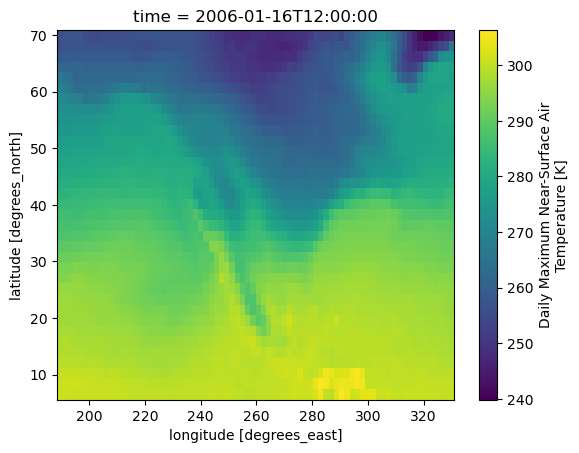

In [1]:
%matplotlib inline
import os

import xarray as xr
from matplotlib import pyplot as plt

verify_ssl = True if "DISABLE_VERIFY_SSL" not in os.environ else False

# The OPeNDAP link for the test file
dap = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/"
ncfile = "birdhouse/testdata/flyingpigeon/cmip5/tasmax_Amon_MPI-ESM-MR_rcp45_r1i1p1_200601-200612.nc"

# Here we open the file and subset it using xarray functionality, which communicates directly with
# the OPeNDAP server to retrieve only the data needed.
ds = xr.open_dataset(dap + ncfile)
tas = ds.tasmax
subtas = tas.sel(
    time=slice("2006-01-01", "2006-03-01"), lon=slice(188, 330), lat=slice(6, 70)
)
subtas.isel(time=0).plot()
plt.show()

You can then simply write the subset to a local file with `subtas.to_netcdf('subtas.nc')`.

## Subset processes with WPS and Finch

For more
PAVICS offers a number of subsetting processes through the FlyingPigeon WPS server:
 - subset_bbox
 - subset_gridpoint
 - subset_polygon

The `subset_bbox` process takes the geographical coordinates of the two opposite corner of a rectangle to define the subset region, `subset_gridpoint` returns grid cells closest to the given coordinates, while `subset_polygon` returns the grid cells within a user-defined polygon.

The first step to launch those services is to create a connexion to the WPS server using Birdy's `WPSClient`.

In [2]:
from birdy import WPSClient

url = "https://pavics.ouranos.ca/twitcher/ows/proxy/finch/wps"
wps = WPSClient(url, verify=verify_ssl)

Now we'll use `wps.subset_gridpoint`, so let's first check what arguments it expects and pass those to the function.

In [3]:
help(wps.subset_gridpoint)

Help on method subset_gridpoint in module birdy.client.base:

subset_gridpoint(resource, lon, lat=None, start_date=None, end_date=None, variable=None) method of birdy.client.base.WPSClient instance
    Return the data for which grid cells includes the point coordinates for each input dataset as well as the time range selected.
    
    Parameters
    ----------
    resource : ComplexData:mimetype:`application/x-netcdf`, :mimetype:`application/x-ogc-dods`
        NetCDF files, can be OPEnDAP urls.
    lon : string
        Longitude coordinate. Accepts a comma separated list of floats for multiple grid cells.
    lat : string
        Latitude coordinate. Accepts a comma separated list of floats for multiple grid cells.
    start_date : string
        Initial date for temporal subsetting. Can be expressed as year (%Y), year-month (%Y-%m) or year-month-day(%Y-%m-%d). Defaults to first day in file.
    end_date : string
        Final date for temporal subsetting. Can be expressed as year (%

In [4]:
thredds = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/fileServer/"
ncfile = "birdhouse/testdata/flyingpigeon/cmip5/tasmax_Amon_MPI-ESM-MR_rcp45_r1i1p1_200601-200612.nc"
resp = wps.subset_gridpoint(resource=thredds + ncfile, lon=200, lat=50)

The response we're getting can either include the data itself or a reference to the data. Using the `get` method of the response object, we'll get what was included in the response. If the response holds only a reference (link) to the output, we can retrieve it using the `get(as_obj=True)` method. Birdy will then inspect the file format of each output and try to find the appropriate way to open the file and return a Python object. A warning is issued if no converter is found, in which case the original reference is returned.

In [5]:
res = resp.get()
print("URL: ", res.output)
res = resp.get(asobj=True)
res.output

URL:  https://pavics.ouranos.ca/wpsoutputs/finch/73b5a324-2089-11f0-888f-0242ac13000f/tasmax_amon_mpi_esm_mr_rcp45_r1i1p1_200601_200612_sub.nc


<xarray.Dataset> Size: 385B
Dimensions:             (time: 12, region: 1, bnds: 2)
Coordinates:
  * time                (time) datetime64[ns] 96B 2006-01-16T12:00:00 ... 200...
    lat                 float64 8B ...
    lon                 float64 8B ...
Dimensions without coordinates: region, bnds
Data variables:
    time_bnds           (region, time, bnds) datetime64[ns] 192B ...
    lat_bnds            (region, bnds) float64 16B ...
    lon_bnds            (region, bnds) float64 16B ...
    latitude_longitude  (region) |S1 1B ...
    tasmax              (region, time) float32 48B ...
Attributes: (12/27)
    institution:            Max Planck Institute for Meteorology
    institute_id:           MPI-M
    experiment_id:          rcp45
    source:                 MPI-ESM-MR 2011; URL: http://svn.zmaw.de/svn/cosm...
    model_id:               MPI-ESM-MR
    forcing:                GHG,Oz,SD,Sl,Vl,LU
    ...                     ...
    table_id:               Table Amon (27 April 2011) a5a1c518f52ae340313ba0...
    title:                  MPI-ESM-MR model output prepared for CMIP5 RCP4.5
    parent_experiment:      historical
    modeling_realm:         atmos
    realization:            1
    cmor_version:           2.6.0